In [1]:
import gym
from agent import Agent
from collections import deque
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
# Setting seaborn style
sns.set()

# Functions for visualizing

In [2]:
def ma(x, w):
    """Rolling average"""
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
def break200point(scores, x):
    i = 0
    for s in scores:
        if s >= x:
            return i+1
        i += 1
    #return next(x[0] for x in enumerate(scores) if x[1] >= 200.0)

In [4]:
def plot_results(scores, eps_history, episodes):
    fig=plt.figure(figsize=(12, 6))
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    # Episodes
    x = [i+1 for i in range(episodes)]

    ax.plot(x, 
            eps_history, 
            color="C0", 
            label='Epsilon history')
    ax.set_xlabel("Episodes", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    ax2.plot([x for x in range(len(scores))], 
             scores, 
             color='gray',
             label='Score')

    point200 = break200point(ma(scores, 100), 200.0)
    point200str = 'step {}'.format(point200) if point200 else 'N/A'
    # print('\tBroke 200 point barrier: {}'.format(point200str))

    if point200:
        y = ma(scores, 100)[point200]
        plt.scatter(point200+100, y, color='red', marker='o', s=50)

    yavg = ma(scores, 100)
    xavg = [x+100 for x in range(len(yavg))]

    # Plotting the first segment in blue
    if point200:
        plt.plot(xavg[:point200], yavg[:point200], color='blue', label='Average sore before 200 mark')

        # Plotting the second segment in red
        plt.plot(xavg[point200:], yavg[point200:], color='C1', label='Average score after 200 mark')
    else:
        ax2.plot(xavg, 
                 ma(scores, 100), 
                 color='blue',
                 label='Score MA100')

    # Adding a legend to the plot
    plt.legend()
    plt.show()

##  All simulations are run with the following parameters:

`gamma`: 1.0\
`lr`: 0.001\
`batch_size`: 64\
`memory_size`: 100.000\
`eps_start`: 1.0 # Initial epsilon\
`eps_end`: 0.01 # Final epsilon after decaying for 10k steps\
`eps_decay`: 0.999\
`tau`: 0.001

#### For the training we use the soft update, discussed in this [paper](https://arxiv.org/pdf/1509.02971.pdf).
The paper recommends slowly copying the weights over from the target network to the local network, and generally this is done by copying the weights every 4 episodes. Here will test this.\
We will try the soft update and test it by updating the model after every episode, every 2 episode and finally after every 4 episodes.\
All the other parameters stay the same.

# Main function that puts everything together

In [64]:
def dqn(n_episodes=1000, max_t=2000, eps_decay=0.995, batch_size=64, update_every=4):
    agent.eps_decay = eps_decay
    agent.memory_size = 32000
    state = env.reset()[0]

    scores, eps_history = [], []       # List containing scores and eps from each episode
    scores_window = deque(maxlen=100)  # Last 100 scores
    solved = False
    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            # Stores memory and trains network
            agent.step_soft(state, action, reward, next_state, terminated, update_every=update_every) 
            state = next_state
            score += reward
            
            # Decay the epsilon
            agent.eps = max(agent.eps_end, agent.eps_decay*agent.eps) 
            if terminated or truncated:
                break
        eps_history.append(agent.eps)
        scores_window.append(score)       # Save score of current episode
        scores.append(score)              # Save score of current episode

        print('\rEpisode {}\tAverage Score: {:.2f}\t\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), 
                                                                              agent.eps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0 and not solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
            # Export model when avg reward hits 200 mark
            agent.save_model("Exported_models/Soft_update_" + str(eps_decay) + "_" + str(update_every) + "_" + str(i_episode) + ".pth")

    # Export the final model as well
    agent.save_model("Exported_models/Soft_update_" + str(eps_decay) + "_" + str(update_every) + "_" + str(i_episode) + ".pth")
    env.close()
    return scores, eps_history, i_episode

### Updating model weights after every episode

In [22]:
env = gym.make("LunarLander-v2")
agent = Agent()
scores, eps_history, episodes = dqn(n_episodes=2000, eps_decay=0.999, update_every=1)

Episode 100	Average Score: -144.94		Epsilon: 0.01
Episode 200	Average Score: -74.35		Epsilon: 0.011
Episode 300	Average Score: -59.91		Epsilon: 0.01
Episode 400	Average Score: 16.75		Epsilon: 0.011
Episode 500	Average Score: 176.14		Epsilon: 0.01
Episode 534	Average Score: 200.09		Epsilon: 0.01
Environment solved in 534 episodes!	Average Score: 200.09
Episode 600	Average Score: 232.51		Epsilon: 0.01
Episode 700	Average Score: 56.54		Epsilon: 0.011
Episode 800	Average Score: -73.49		Epsilon: 0.01
Episode 900	Average Score: -255.36		Epsilon: 0.01
Episode 1000	Average Score: -195.65		Epsilon: 0.01
Episode 1100	Average Score: -197.01		Epsilon: 0.01
Episode 1200	Average Score: -493.76		Epsilon: 0.01
Episode 1300	Average Score: -634.48		Epsilon: 0.01
Episode 1400	Average Score: -797.09		Epsilon: 0.01
Episode 1500	Average Score: -927.34		Epsilon: 0.01
Episode 1600	Average Score: -793.01		Epsilon: 0.01
Episode 1700	Average Score: -915.67		Epsilon: 0.011
Episode 1800	Average Score: -2601.32		Ep

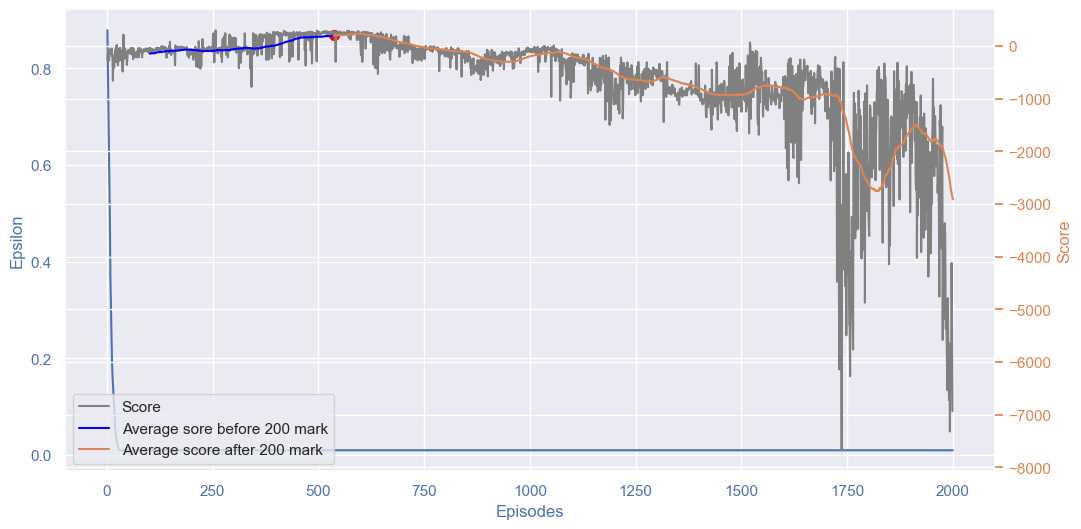

In [23]:
plot_results(scores, eps_history, episodes)

### Updating model weights after every 2 episodes

In [25]:
env = gym.make("LunarLander-v2")
agent = Agent()
scores, eps_history, episodes = dqn(n_episodes=2000, eps_decay=0.999, update_every=2)

Episode 100	Average Score: -147.43		Epsilon: 0.01
Episode 200	Average Score: -32.23		Epsilon: 0.011
Episode 300	Average Score: 59.56		Epsilon: 0.011
Episode 400	Average Score: 91.21		Epsilon: 0.01
Episode 500	Average Score: 128.71		Epsilon: 0.01
Episode 531	Average Score: 200.29		Epsilon: 0.01
Environment solved in 531 episodes!	Average Score: 200.29
Episode 600	Average Score: 203.99		Epsilon: 0.01
Episode 700	Average Score: 243.07		Epsilon: 0.01
Episode 800	Average Score: 251.40		Epsilon: 0.01
Episode 900	Average Score: 256.90		Epsilon: 0.01
Episode 1000	Average Score: 254.18		Epsilon: 0.01
Episode 1100	Average Score: 200.85		Epsilon: 0.01
Episode 1200	Average Score: 112.47		Epsilon: 0.01
Episode 1300	Average Score: -7.67		Epsilon: 0.011
Episode 1400	Average Score: -5.32		Epsilon: 0.01
Episode 1500	Average Score: -37.74		Epsilon: 0.01
Episode 1600	Average Score: -187.57		Epsilon: 0.01
Episode 1700	Average Score: -394.49		Epsilon: 0.01
Episode 1800	Average Score: -446.11		Epsilon: 0.01

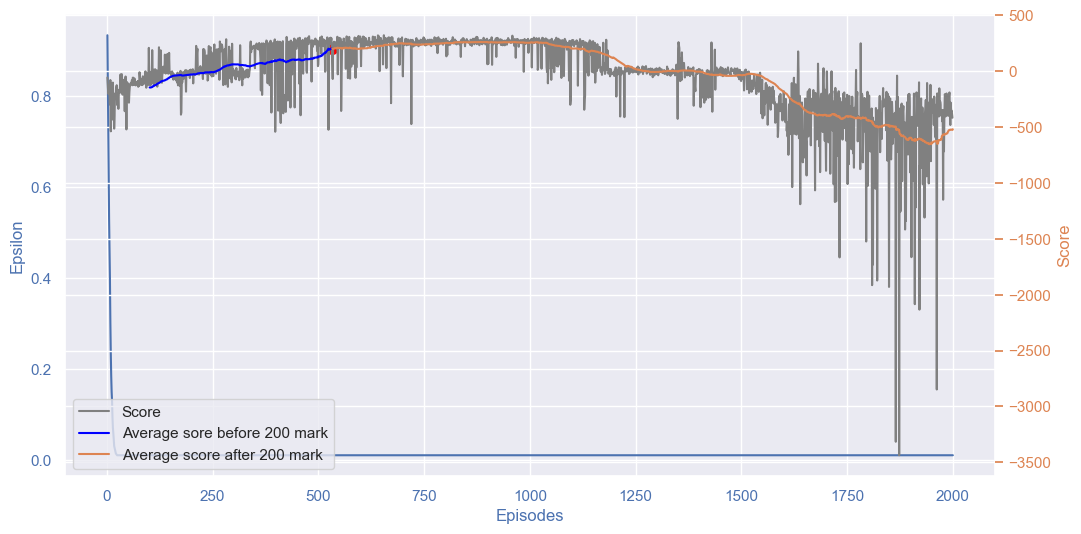

In [26]:
plot_results(scores, eps_history, episodes)

### Updating model weights after every 4 episodes

In [19]:
env = gym.make("LunarLander-v2")
agent = Agent()
scores, eps_history, episodes = dqn(n_episodes=2000, eps_decay=0.999, update_every=4)

Episode 100	Average Score: -229.75		Epsilon: 0.01
Episode 200	Average Score: -85.60		Epsilon: 0.011
Episode 300	Average Score: -57.16		Epsilon: 0.01
Episode 400	Average Score: -26.85		Epsilon: 0.01
Episode 500	Average Score: -8.57		Epsilon: 0.011
Episode 600	Average Score: 2.37		Epsilon: 0.0111
Episode 700	Average Score: 121.88		Epsilon: 0.01
Episode 800	Average Score: 164.59		Epsilon: 0.01
Episode 822	Average Score: 202.24		Epsilon: 0.01
Environment solved in 822 episodes!	Average Score: 202.24
Episode 900	Average Score: 191.12		Epsilon: 0.01
Episode 1000	Average Score: 85.58		Epsilon: 0.01
Episode 1100	Average Score: 204.21		Epsilon: 0.01
Episode 1200	Average Score: 242.17		Epsilon: 0.01
Episode 1300	Average Score: 229.17		Epsilon: 0.01
Episode 1400	Average Score: 208.91		Epsilon: 0.01
Episode 1500	Average Score: 196.48		Epsilon: 0.01
Episode 1600	Average Score: 212.70		Epsilon: 0.01
Episode 1700	Average Score: 238.63		Epsilon: 0.01
Episode 1800	Average Score: 264.74		Epsilon: 0.01
E

**Conclusion**: It's clear to see that the model should slowly be updated, once every 4 episodes, as this keeps it stable and allows it to keep increasing the average score. Updating it every episode or every other 2 episodes causes for instabilities later on, which drop the average score from well above the 200 mark, all the way down to even in the negatives.

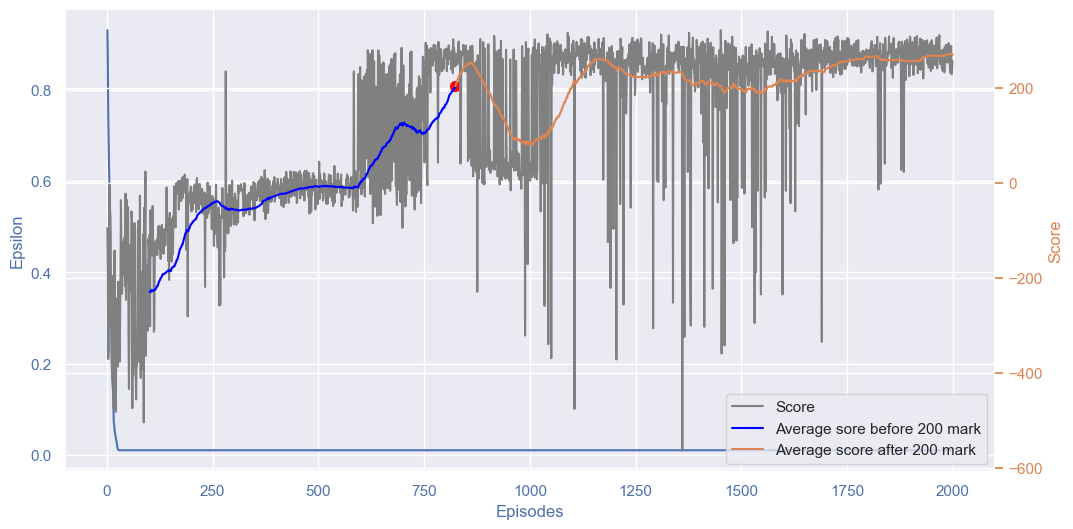

In [20]:
plot_results(scores, eps_history, episodes)

### Same as above, just was curious about 1000 episodes instead

In [65]:
env = gym.make("LunarLander-v2")
agent = Agent()
scores, eps_history, episodes = dqn(n_episodes=1000, eps_decay=0.999, update_every=4)

Episode 100	Average Score: -165.16		Epsilon: 0.01
Episode 200	Average Score: -102.06		Epsilon: 0.01
Episode 300	Average Score: -48.91		Epsilon: 0.01
Episode 400	Average Score: -27.31		Epsilon: 0.01
Episode 500	Average Score: -16.45		Epsilon: 0.01
Episode 600	Average Score: 24.66		Epsilon: 0.011
Episode 700	Average Score: 139.46		Epsilon: 0.01
Episode 762	Average Score: 200.09		Epsilon: 0.01
Environment solved in 762 episodes!	Average Score: 200.09
Episode 800	Average Score: 210.94		Epsilon: 0.01
Episode 900	Average Score: 240.43		Epsilon: 0.01
Episode 1000	Average Score: 232.42		Epsilon: 0.01


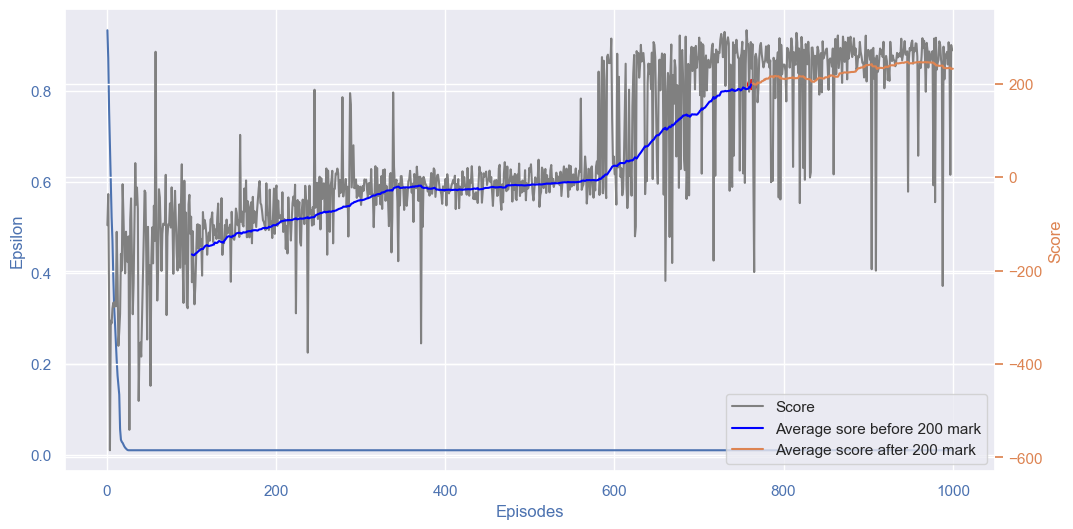

In [70]:
plot_results(scores, eps_history, episodes)

# Loading and testing the models

In the following cells, we will load the models and test them.\
There was an issue however where most of the models performed extremely bad and nowhere near to how they performed before they were exported.

**However**, there was also one which was exported perfect, you can find that one at the end. The exact reason of why the exporting/loading of the other models is unknown.

In [20]:
def dqn_test(model_path, n_episodes=100, max_t=2000, eps=1):
    agent.eps = eps
    agent.load_model(model_path)

    scores = []                           # List containing scores from each episode
    scores_window = deque(maxlen=100)     # Last 100 scores
    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            score += reward
            if terminated or truncated:
                break
        scores_window.append(score)       # Save score of current episode
        scores.append(score)              # Save score of current episode
        print('\nEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")
    print('\n\n Total Average Score: {:.2f}'.format(np.mean(scores_window)), end="")        
    env.close()
    return scores, i_episode

In [11]:
env = gym.make("LunarLander-v2")
agent = Agent()
model_path = 'Exported_models/Soft_update_0.999_4_2000.pth'

scores, i_episode = dqn_test(model_path=model_path, n_episodes=200, eps=0)


Episode 1	Score: -341.92
Episode 2	Score: -260.01
Episode 3	Score: -343.55
Episode 4	Score: -319.24
Episode 5	Score: -536.76
Episode 6	Score: -242.53
Episode 7	Score: 228.13
Episode 8	Score: -493.46
Episode 9	Score: -252.26
Episode 10	Score: 178.97
Episode 11	Score: -486.89
Episode 12	Score: 257.65
Episode 13	Score: -226.37
Episode 14	Score: -396.51
Episode 15	Score: -602.93
Episode 16	Score: 291.91
Episode 17	Score: -520.27
Episode 18	Score: -390.90
Episode 19	Score: 269.53
Episode 20	Score: -334.44
Episode 21	Score: 205.37
Episode 22	Score: -383.26
Episode 23	Score: -260.87
Episode 24	Score: 236.99
Episode 25	Score: -422.72
Episode 26	Score: -348.25
Episode 27	Score: 257.94
Episode 28	Score: -355.46
Episode 29	Score: -371.38
Episode 30	Score: -266.24
Episode 31	Score: -358.73
Episode 32	Score: -221.67
Episode 33	Score: -364.16
Episode 34	Score: -592.33
Episode 35	Score: -348.07
Episode 36	Score: -334.00
Episode 37	Score: -322.46
Episode 38	Score: 203.70
Episode 39	Score: 266.08
Epis

In [12]:
env = gym.make("LunarLander-v2")
agent = Agent()
path = 'Exported_models/Soft_update_0.999_4_822.pth'

scores, i_episode = dqn_test(model_path=model_path, n_episodes=200, eps=0)


Episode 1	Score: 218.91
Episode 2	Score: -303.35
Episode 3	Score: -254.43
Episode 4	Score: 267.13
Episode 5	Score: -510.42
Episode 6	Score: 238.30
Episode 7	Score: -516.17
Episode 8	Score: 275.42
Episode 9	Score: -365.04
Episode 10	Score: 260.90
Episode 11	Score: -362.41
Episode 12	Score: -291.89
Episode 13	Score: -200.89
Episode 14	Score: 204.40
Episode 15	Score: -270.29
Episode 16	Score: 250.33
Episode 17	Score: 287.11
Episode 18	Score: -447.63
Episode 19	Score: -674.08
Episode 20	Score: 253.00
Episode 21	Score: -245.07
Episode 22	Score: -303.05
Episode 23	Score: 270.76
Episode 24	Score: -257.23
Episode 25	Score: -273.37
Episode 26	Score: -425.52
Episode 27	Score: -207.19
Episode 28	Score: 289.27
Episode 29	Score: -238.57
Episode 30	Score: -588.32
Episode 31	Score: -409.91
Episode 32	Score: -238.89
Episode 33	Score: -535.49
Episode 34	Score: -434.29
Episode 35	Score: -337.23
Episode 36	Score: -438.89
Episode 37	Score: -398.72
Episode 38	Score: -295.09
Episode 39	Score: -340.22
Episo

### Final model

In [21]:
env = gym.make("LunarLander-v2")
agent = Agent()
model_path = 'Exported_models/Soft_update_0.999_2_531.pth'

scores, i_episode = dqn_test(model_path=model_path, n_episodes=200, eps=0)


Episode 1	Score: 239.23
Episode 2	Score: 292.97
Episode 3	Score: 276.45
Episode 4	Score: 246.60
Episode 5	Score: 281.81
Episode 6	Score: 287.34
Episode 7	Score: -235.65
Episode 8	Score: 238.68
Episode 9	Score: 245.70
Episode 10	Score: 239.35
Episode 11	Score: 297.68
Episode 12	Score: 280.51
Episode 13	Score: 310.12
Episode 14	Score: 251.80
Episode 15	Score: 250.79
Episode 16	Score: -53.92
Episode 17	Score: 262.34
Episode 18	Score: 275.71
Episode 19	Score: 106.08
Episode 20	Score: 276.42
Episode 21	Score: 246.25
Episode 22	Score: 286.91
Episode 23	Score: 289.79
Episode 24	Score: -55.09
Episode 25	Score: 266.34
Episode 26	Score: 205.42
Episode 27	Score: 273.71
Episode 28	Score: 290.70
Episode 29	Score: 284.61
Episode 30	Score: 310.44
Episode 31	Score: 239.95
Episode 32	Score: 302.46
Episode 33	Score: 3.65
Episode 34	Score: 237.76
Episode 35	Score: 286.38
Episode 36	Score: 296.64
Episode 37	Score: 280.45
Episode 38	Score: 219.90
Episode 39	Score: 276.96
Episode 40	Score: 268.90
Episode 4

# Reflection 
**First problem**\
Compared to other assignments, this is the first one where I needed external guidance/guides on how to build the agent/model/memory and the model. I was stuck for a while, trying to figure out how to do it by myself, until I realized that I just had to search for existing implementations to learn from. This ended up taking quite a lot of time, which was the first, main problem.\

**Second problem**\
The 2nd issue, once the memory, model and the main components of the agent and code for training the model were completed, was finding out how to improve the model as it takes quite a lot of training to converge. I ended up finding out it's possible to make it converge after around 500 episodes, however this made it very unstable later on during further training. I ended up accepting the fact that it takes it around 800 episodes to train, which allows it to train and improve the average score even further.

I've also experimented with many hyperparameters, such as varying eps_decay, memory_sizes, but they didn't make much of a difference.